<h2><B><left>Hello, This Notebook Contains example of Bank Deposite classification.</left></B></h2>
<h4><I><left>- We try to predict if the bank campaign should contact with cretain customer.</left></I></h4>
<h4><I><left>- We use Pandas library for data exploratory, Seaborn Library for visualize data(found in bank_visualization file).</left></I></h4>
<h4><I><left>- We use Scikit-Learn library for training and testing models.</left></I></h4>
<h4><I><left>- We implement different techniques for feature selection, and we use Grid_Search technique for parameters tunning.</left></I></h4>
<h4><I><left>- Finally we save all results in 'results.csv' file</left></I></h4>
<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
            <li><h3>Contents:</h3></li>
   <ul>
        <li><h4><a href="#exploratory">Data Exploratory.</a></h4></li>
        <li><h4><a href="#prep">Prepocessing.</a></h4></li>
         <ul>
             <li><a href="#call">call estimators</a></li>
            <li><a href="#pipline">create piplines</a></li>
             <li><a href="#split">split data</a></li>
        </ul>
        <li><h4><a href="#model">Modeling.</a></h4></li>
        <li><h4><a href="#results">Results.</a></h4></li>
         <ul>
            <li><a href="#roc_auc">plot destination metric</a></li>
            <li><a href="#prev_res">previous results</a></li>
             <li><a href="#learning_curve">plot learning curve</a></li>
        </ul>
    </ul>
    </ul>
</div>
<hr>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils as uts

<a id="exploratory"></a>
<h3><B><left>- Data Exploratory:</left></B></h3>
<h4><I><left>- reading data set and plotting some statistical values.</left></I></h4>
<h4><I><left>- visualization processes found in another file (bank_deposit_data_visualization.ipynb).</left></I></h4>

-----------------

In [2]:
try:
    bank = pd.read_csv('../Data/bank1/bank.csv')
    names_parser = uts.namesParser()
    results_management = uts.resultsManagement('results.csv')
except Exception as ex:
    print('some Error!',ex)
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


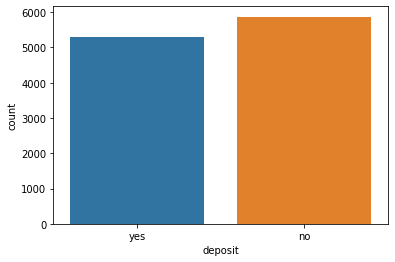

In [3]:
sns.countplot(x='deposit',data=bank)

In [66]:
bank.education.value_counts()

secondary    5869
tertiary     3784
primary      1509
Name: education, dtype: int64

In [67]:
bank.job.value_counts()

management       2575
blue-collar      1990
technician       1838
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

<h4><left>- helper methods.</left></h4>

In [4]:
# helper methods
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def split_data(data,y_label,test_size=0.2):
    bo = uts.booleanEncoder() 
    
    X = data.loc[:,~data.columns.isin([y_label])]
    y = data.loc[:,y_label]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    y_train = bo.fit_transform(y_train)
    y_test = bo.fit_transform(y_test)
    return X_train, X_test,y_train,y_test

def get_metrices(model,X_test,y_test):
    y_predict= model.predict(X_test)
    return accuracy_score(y_test, y_predict),precision_score(y_test, y_predict),recall_score(y_test, y_predict),f1_score(y_test, y_predict)

def print_results(accuracy,precision,recall,f1):
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}'.format(f1))
    
def descritize_column(column,bins):
    return pd.cut(column.values,bins=bins[column.name],right=False).codes

<a id="prep"></a>
<h3><B><left>- Preprocessing:</left></B></h3>
<h4><I><left>- call our estimators from 'utils.py' file.</left></I></h4>
<h4><I><left>- create preprocessing piplines for both numerical and categorical features.</left></I></h4>
<h4><I><left>- splitting data then fitting on train, and transorming on test.</left></I></h4>

--------------------

<a id="call"></a>
<h4><I><left>- call our unknownImputer from 'utils.py' file for filling null values depends on values in another columns, we ellaborate that in our paper.</left></I></h4>

In [61]:
# here we try to descritize ages.

# import numpy as np
# bins = {
#     'age' : [0,18,30,40,55,np.inf],
#     'balance' :  [0,500,2000,2800,3700,np.inf]
# }
# bank[['age','balance']]=bank[['age','balance']].apply(descritize_column,bins=bins) 

je_imputer = uts.unknownImputer(nan_column='job',related_column='education')
bank = ui.fit_transform(bank)

ej_imputer = uts.unknownImputer(nan_column='education',related_column='job')
bank= ej_imputer.fit_transform(bank)
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


<a id="pipline"></a>
<h4><I><left>- create preprocessing piplines for Numerical, Categorical and Boolean features.</left></I></h4>

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


numeric_preprocess = Pipeline([('fields',uts.featureSelector(['age','duration','campaign','day','pdays','previous','balance'])),
#                                ("polynomial_features", PolynomialFeatures(degree=3)),
                               ('scaler',StandardScaler())
                              ])

cat_preprocess = Pipeline([('fields',uts.featureSelector(['job','marital','education','contact','month'])),
                           ('encoder', OneHotEncoder(sparse=False)),])

boolean_preprocess = Pipeline([('fields',uts.featureSelector(['housing','loan'])),
                               ('encoder',uts.booleanEncoder())])

preprocess_features = FeatureUnion(transformer_list = [
    ('num',numeric_preprocess),
    ('cat',cat_preprocess),
    ('bool',boolean_preprocess)
])

<a id="split"></a>
<h4><I><left>- split data then fit on train, transform on test.</left></I></h4>

In [63]:
X_train,X_test,y_train,y_test = split_data(bank,'deposit')

In [64]:
X_train = preprocess_features.fit_transform(X_train)
X_test = preprocess_features.transform(X_test)

<a id="model"></a>
<h3><B><left>- Modeling:</left></B></h3>
<h4><I><left>- create model pipline.</left></I></h4>
<h4><I><left>- implement grid search technique for tunning model parameters.</left></I></h4>

----------------------

In [65]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC , LinearSVC
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


select_from_model = SelectFromModel(
   DecisionTreeClassifier(max_depth=10))

model_pipline = Pipeline([
#  ("feature_selection", select_from_model),
#  ('classifier',SVC(kernel='poly',C=10,coef0=1,degree=2))
 ('classifier',XGBClassifier())
#    ('classifier',SVC())
#  ('classifier',DecisionTreeClassifier())
 ])

param_grid = [{
#    "feature_selection__percentile": [80,70,60],
#     "classifier__n_estimators":[100,200], 
#     "classifier__gamma":[0.001,0.005,0.01],
#       "classifier__gamma":[0.001,0.005,0.01],
#       "classifier__C":[5,10],
#     "feature_selection__estimator__max_depth": [7,10,15],
#     "classifier__max_depth":[30],
 }]

grid_search = GridSearchCV(model_pipline, param_grid, cv=3)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
acc,pre,rec,f1 = get_metrices(model,X_test,y_test)
print_results(acc,pre,rec,f1)

[00:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

<a id="results"></a>
<h3><B><left>- Result: </left></B></h3>
<h4><I><left>- plot ROC-AUC curve which is our destination metric.</left></I></h4>
<h4><I><left>- show previous results, save new result into results file, the result contain(algorithm, all hyper parameters, score metrices).</left></I></h4>
<h4><I><left>- plot learning curve.</left></I></h4>

---------------

<a id="roc_auc"></a>
<h4><left>- plot ROC-AUC metric.</left></h4>

In [288]:
try:
    y_predicted = grid_search.decision_function(X_test)
except:
    y_predicted = grid_search.predict_proba(X_test)[:,1]

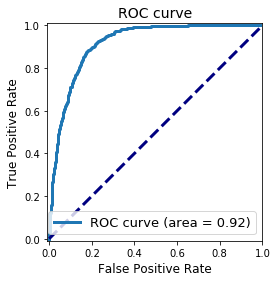

In [289]:
from sklearn.metrics import roc_curve, auc
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_predicted)
roc_auc = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

<a id="prev_res"></a>
<h4><left>- previous results and save new result</left></h4>

In [82]:
results_management.results.head(10)

,Model,Scaler,Features,Feature Selection,Accurecy on Test,Recall,Precession,Parameters,Polynomial Features,Roc AUC
0,LogisticRegression,StandardScaler,all,manual,0.808330,0.780694,0.811100,{'c': 1},NaN,NaN
1,LogisticRegression,RobustScaler,all,manual,0.810121,0.774133,0.818632,{'c': 1},NaN,NaN
2,LogisticRegression,RobustScaler,all,manual,0.811464,0.777882,0.818540,(C=100),NaN,NaN
3,LogisticRegression,RobustScaler,all,manual,0.809225,0.773196,0.817641,(C=1000),NaN,NaN
4,LogisticRegression,RobustScaler,all,manual,0.778325,0.713215,0.801053,(C=0.001),NaN,NaN
5,LogisticRegression,RobustScaler,(percentile=100),SelectPercentile(percentile=100),0.810121,0.774133,0.818632,(percentile=100)),NaN,NaN
6,LogisticRegression,RobustScaler,(percentile=100),SelectPercentile,0.810121,0.774133,0.818632,(C=1),NaN,NaN
7,LogisticRegression,RobustScaler,(percentile=95),SelectPercentile,0.815047,0.778819,0.824405,(C=10),NaN,NaN
8,LogisticRegression,RobustScaler,(random_state=42),SelectFromModel,0.802956,0.763824,0.812562,(C=1),NaN,NaN
9,LogisticRegression,RobustScaler,"(n_estimators=50, random_state=42))",RFE,0.805643,0.772259,0.811823,(C=0.1),NaN,NaN


In [291]:
result = {
    'Model':names_parser.get_element_name(model.get_params().get('classifier')),
    'Scaler':names_parser.get_element_name(numeric_preprocess.get_params().get('scaler','-')),
    'Features':names_parser.get_element_params(model.get_params().get('feature_selection','-')),
    'Feature Selection':names_parser.get_element_name(model.get_params().get('feature_selection','')),
    'Accurecy on Test':acc,
    'Recall':rec,
    'Precession':pre,
    'Parameters':names_parser.get_element_params(model.get_params().get('classifier')),
    'Polynomial Features':names_parser.get_element_params(numeric_preprocess.get_params().get('polynomial_features','-')),
    'Roc AUC':roc_auc
}
results_management.add_to_results(result=result).tail(10)

,Model,Scaler,Features,Feature Selection,Accurecy on Test,Recall,Precession,Parameters,Polynomial Features,Roc AUC
42,DecisionTreeClassifier,StandardScaler,percentile=60,SelectPercentile,0.785043,0.816307,0.754113,max_depth=7,-,NaN
43,DecisionTreeClassifier,StandardScaler,percentile=50,SelectPercentile,0.799821,0.790066,0.790807,max_depth=7,degree=3,NaN
44,DecisionTreeClassifier,StandardScaler,percentile=80,SelectPercentile,0.813704,0.814433,0.799448,max_depth=7,degree=4,NaN
45,DecisionTreeClassifier,-,percentile=50,SelectPercentile,0.808330,0.799438,0.799438,max_depth=7,degree=3,NaN
46,DecisionTreeClassifier,-,percentile=80,SelectPercentile,0.807882,0.835052,0.778846,max_depth=7,degree=4,NaN
47,RandomForestClassifier,RobustScaler,percentile=60,SelectPercentile,0.806538,0.816307,0.786811,max_depth=10,-,NaN
48,RandomForestClassifier,RobustScaler,percentile=80,SelectPercentile,0.810121,0.824742,0.787825,max_depth=15,-,NaN
49,RandomForestClassifier,RobustScaler,-,-,0.811912,0.819119,0.793824,max_depth=15,-,NaN
50,RandomForestClassifier,MinMaxScaler,-,-,0.807882,0.812559,0.791058,max_depth=10,-,NaN
51,XGBClassifier,StandardScaler,-,-,0.846843,0.866917,0.822222,"base_score=0.5,booster='gbtree',colsample_byle...",-,0.918722


In [293]:
results_management.save_results()

In [295]:
pd.DataFrame(results_management.results.loc[51])

,51
Model,XGBClassifier
Scaler,StandardScaler
Features,-
Feature Selection,-
Accurecy on Test,0.846843
Recall,0.866917
Precession,0.822222
Parameters,"base_score=0.5,booster='gbtree',colsample_byle..."
Polynomial Features,-
Roc AUC,0.918722


<a id="learning_curve"></a>
<h4><left>- plot learning curve.</left></h4>

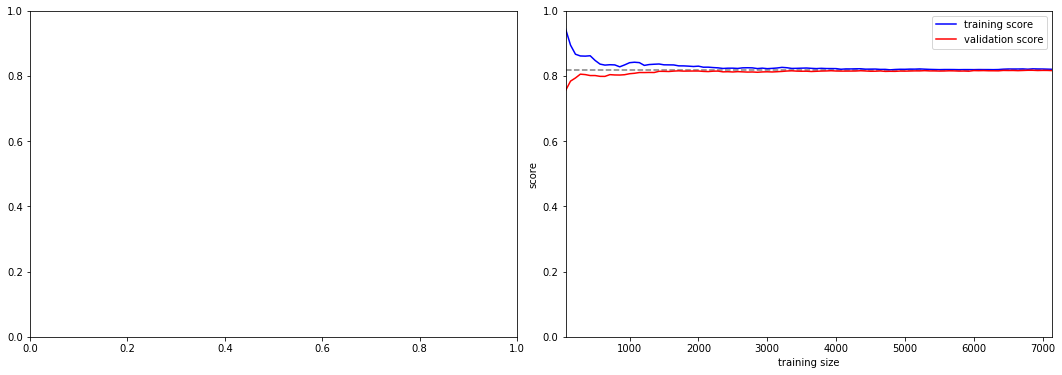

In [81]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# for i, degree in enumerate([2, 9]):
N, train_lc, val_lc = learning_curve(LogisticRegression(),
                                     X_train, y_train, cv=5,
                                     train_sizes=np.linspace(0.01,1,100))

ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
             color='gray', linestyle='dashed')

ax[i].set_ylim(0, 1)
ax[i].set_xlim(N[0], N[-1])
ax[i].set_xlabel('training size')
ax[i].set_ylabel('score')
# ax[i].set_title('degree = {0}'.format(degree), size=14)
ax[i].legend(loc='best')

<h3><I><B><center>...The End...</center></B></I></h3>